In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
#all imported libraries 

#To calculate accuracy we wrote our own function, it claculates r^2
def coeff_of_determination(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    SS_res = len(predicted_values)*mse
    SS_tot = np.sum((true_values-true_values.mean())**2)
    R2 = 1 - (SS_res/SS_tot)
    return R2


#2015-2019 dataset
dataset = pd.read_csv('data.csv')


# Changes the days from date to which weekday it is
lst = [3,4,5,6,7,1,2]
n = len(dataset['Dag'])
bb=(lst*int(n/7))
bb.append(3)
bb.append(4)
bb.append(5)

df1 = pd.DataFrame({'Dag':bb})

dataset=dataset.assign(Dag=df1['Dag'])

# Storing the feature columns
feature_cols = dataset.columns.drop(['Volum til DNP', 'Volum til SNTR', 'Volum totalt'])

print(dataset)

         År  Måned  Dag  Fra_time  Volum til SNTR  Volum til DNP  Volum totalt
0      2015     12    3        11             265            232           497
1      2015     12    4        12             243            223           466
2      2015     12    5        13             251            289           540
3      2015     12    6        14             369            409           778
4      2015     12    7        15             283            365           648
...     ...    ...  ...       ...             ...            ...           ...
35187  2019     12    1        19              77             72           149
35188  2019     12    2        20              58             61           119
35189  2019     12    3        21              52             51           103
35190  2019     12    4        22              51             39            90
35191  2019     12    5        23              34             81           115

[35192 rows x 7 columns]


In [2]:
#Checking for null values
null= dataset.isnull().any().any()
print(null)


False


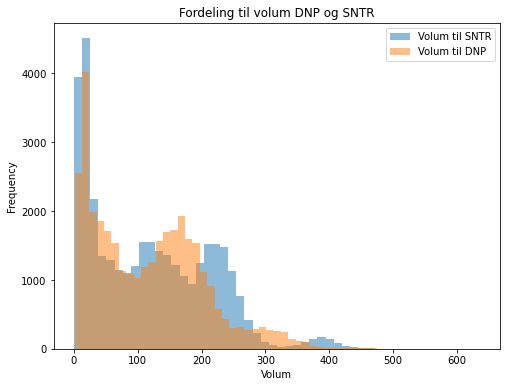

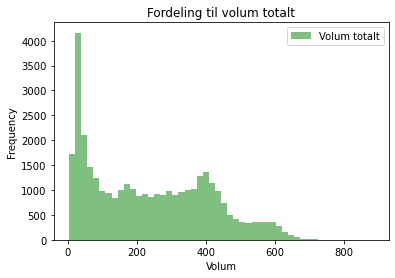

In [3]:
plt.figure(figsize=(8,6))
plt.hist(x=dataset['Volum til SNTR'], bins=50, alpha=0.5, label='Volum til SNTR')#pdf
plt.hist(x=dataset['Volum til DNP'], bins=50, alpha=0.5, label='Volum til DNP')
plt.legend(loc='upper right')
plt.title('Fordeling til volum DNP og SNTR')
plt.xlabel('Volum')
plt.ylabel('Frequency')
plt.show()
plt.hist(x=dataset['Volum totalt'], bins=50, alpha=0.5, label='Volum totalt', color='g')
plt.legend(loc='upper right')
plt.title('Fordeling til volum totalt')
plt.xlabel('Volum')
plt.ylabel('Frequency')
plt.show()

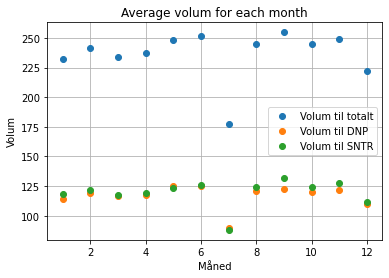

In [4]:
traffic=dataset[['Volum totalt','Volum til DNP', 'Volum til SNTR','Måned']]

mnd = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
traffic_Totalt = dataset[['Volum totalt','Måned']].groupby('Måned').mean()
traffic_DNP = dataset[['Volum til DNP','Måned']].groupby('Måned').mean()
traffic_SNTR = dataset[['Volum til SNTR','Måned']].groupby('Måned').mean()
plt.plot(mnd, traffic_Totalt, 'o', label='Volum til totalt')
plt.plot(mnd, traffic_DNP, 'o', label='Volum til DNP')
plt.plot(mnd, traffic_SNTR, 'o', label='Volum til SNTR')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Måned')
plt.ylabel('Volum')
plt.title('Average volum for each month')
plt.show()

In [5]:
# Changing the months based on the previous plot
måned = np.array(dataset['Måned'])

#July is one period, dec, jan, feb, march, april is the third period and may, june, aug, sept, oct, nov is the second period
for i in range(len(måned)):
    if måned[i] == 7:
        måned[i] = 1
    elif måned[i] in [5,6,8,9,10,11]:
        måned[i] = 2
    else:
        måned[i] = 3

df2 = pd.DataFrame({'Måned':måned})
dataset=dataset.assign(Måned=df2['Måned'])

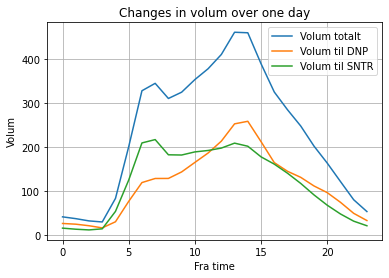

In [6]:
traffic=dataset[['Volum totalt','Volum til DNP', 'Volum til SNTR','Fra_time']]
traffic_per_hour_Totalt = dataset[['Volum totalt','Fra_time']].groupby('Fra_time').mean()
traffic_per_hour_DNP = dataset[['Volum til DNP','Fra_time']].groupby('Fra_time').mean()
traffic_per_hour_SNTR = dataset[['Volum til SNTR','Fra_time']].groupby('Fra_time').mean()
ax = traffic_per_hour_Totalt.plot()
traffic_per_hour_DNP. plot(ax=ax)
traffic_per_hour_SNTR.plot(ax=ax)
plt.grid()
plt.xlabel('Fra time')
plt.ylabel('Volum')
plt.title('Changes in volum over one day')
plt.show()

In [7]:
# One-hot encoding of the features
enc = OneHotEncoder(handle_unknown ='ignore')#instatiate

encdf = pd.DataFrame(enc.fit_transform(dataset[feature_cols].drop(['Fra_time', 'Dag', 'År'], axis=1)).toarray())
encdf['År'] = np.array(dataset['År'])
encdf['Dag'] = np.array(dataset['Dag'])
encdf['Fra_time'] = np.array(dataset['Fra_time'])
encdf['Volum totalt'] = np.array(dataset['Volum totalt'])
encdf['Volum til DNP'] = np.array(dataset['Volum til DNP'])
encdf['Volum til SNTR'] = np.array(dataset['Volum til SNTR'])
#We don't "ohc" År, Dag, Fra_time and the y-columns

encdf.columns = ['Juli', 'Sommertid', 'Vintertid', 'År', 'Dag', 'Fra_time', 'Volum totalt', 'Volum til DNP', 'Volum til SNTR']

Train, Val_Test = train_test_split(encdf, test_size=0.3, random_state=1)
Val, Test = train_test_split(Val_Test, test_size=0.5, random_state=4)

X_train = Train.drop(['Volum totalt', 'Volum til DNP', 'Volum til SNTR'], axis=1)
X_val = Val.drop(['Volum totalt', 'Volum til DNP', 'Volum til SNTR'], axis=1)
X_test = Test.drop(['Volum totalt', 'Volum til DNP', 'Volum til SNTR'], axis=1)
print(X_test.head())

       Juli  Sommertid  Vintertid    År  Dag  Fra_time
15563   0.0        1.0        0.0  2017    5         0
17000   0.0        1.0        0.0  2017    7        21
35095   0.0        0.0        1.0  2019    7        23
27969   0.0        0.0        1.0  2019    7        23
5255    1.0        0.0        0.0  2016    1        10


In [8]:
# Making the features for polynomial regression and support vector regression
Train2, Val_Test2 = train_test_split(dataset, test_size=0.3, random_state=1)
Val2, Test2 = train_test_split(Val_Test2, test_size=0.5, random_state=4)

#Using original dataset without ohc for polynomial and support vector regression
X_train2 = Train2.drop(['Volum totalt', 'Volum til DNP', 'Volum til SNTR', 'År'], axis=1)
X_val2 = Val2.drop(['Volum totalt', 'Volum til DNP', 'Volum til SNTR', 'År'], axis=1)
X_test2 = Test2.drop(['Volum totalt', 'Volum til DNP', 'Volum til SNTR', 'År'], axis=1)

print(X_train2.head())

       Måned  Dag  Fra_time
16959      2    1         4
1010       3    5        13
3254       3    2         1
22493      1    5        17
34178      2    7        18


In [9]:
# Fuctions that creates models and predicts on them, polynomial, rndom forest regressor and support vector regression
def pred_poly_reg(X_train, y_train, X_test, deg):
    model_poly = make_pipeline(PolynomialFeatures(degree=deg), LinearRegression())
    model_poly.fit(X_train, y_train)
    return model_poly.predict(X_test)

def pred_rfr(X_train, y_train, X_test, ne, md):
    rfr = RandomForestRegressor(n_estimators = ne, max_depth=md, random_state=44)
    rfr.fit(X_train, y_train)
    return rfr.predict(X_test)

def pred_svr(X_train, y_train, X_test, c, e, ker):
    regr = make_pipeline(StandardScaler(), SVR(C=c, epsilon=e, kernel=ker))
    regr.fit(X_train, y_train)
    return regr.predict(X_test)


## Totalt

### Polynominal Regression totalt

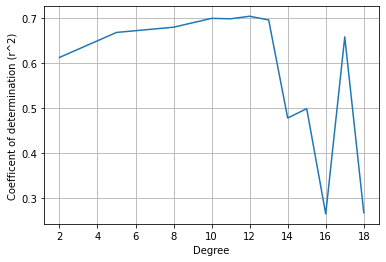

In [10]:
# Checking which degree we should use based on r^2
d = [2, 5, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18]
cod_pr = [] #assessment of each model, which varies with degrees, testing hyperparameter
for i in d:
    pred_tot = pred_tot = pred_poly_reg(X_train2, Train2['Volum totalt'], X_val2, i)
    cod_pr.append(coeff_of_determination(Val2['Volum totalt'], pred_tot))
 
                  
plt.plot(d, cod_pr)
plt.xlabel('Degree')
plt.ylabel('Coefficent of determination (r^2)')
plt.grid()
plt.show()



In [11]:
# Predicting values for volum totalt using the polynomial regression

pred_tot_poly = pred_poly_reg(X_train2, Train2['Volum totalt'], X_val2, 12)
print('Coefficient of determination when using polynominal regression on validation data is: ', str(coeff_of_determination(Val2['Volum totalt'], pred_tot_poly)))


Coefficient of determination when using polynominal regression on validation data is:  0.7042297624125725


###  Random Forest Regressor totalt

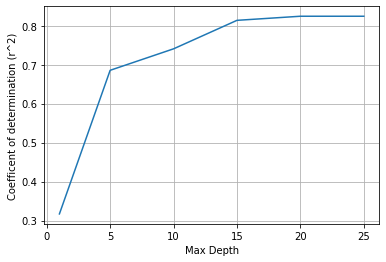

In [12]:
# Checking which max depth we should use based on r^2

hp_md = [1, 5, 10, 15, 20, 25]

cod_tot = [] #assessment of each model, which varies with max depth, testing hyperparameter

for i in hp_md:
    pred_tot_rfr = pred_rfr(X_train, Train['Volum totalt'], X_val, 100, i)
    cod_tot.append(coeff_of_determination(Val['Volum totalt'], pred_tot_rfr))

    
plt.plot(hp_md, cod_tot)
plt.xlabel('Max Depth')
plt.ylabel('Coefficent of determination (r^2)')
plt.grid()
plt.show()

In [13]:
# Predicting values for volum totalt using the random forest regression

pred_tot_rfr = pred_rfr(X_train, Train['Volum totalt'], X_val, 100, 20)
print('Coefficient of determination when using RandomForrestRegression on validation data is:', str(coeff_of_determination(Val['Volum totalt'], pred_tot_rfr)))


Coefficient of determination when using RandomForrestRegression on validation data is: 0.8243196816190363


### SVR totalt

In [14]:
# Predicting values for volum totalt using the support vector regression

pred_tot_svr = pred_svr(X_train2, Train2['Volum totalt'], X_val2, 1.5, 0.2, 'rbf')
print('Coefficient of determination when using support vector regression on validation data is:', str(coeff_of_determination(Val2['Volum totalt'], pred_tot_svr)))

Coefficient of determination when using support vector regression on validation data is: 0.6563214738242005


## Til DNP

### Polynominal Regression DNP

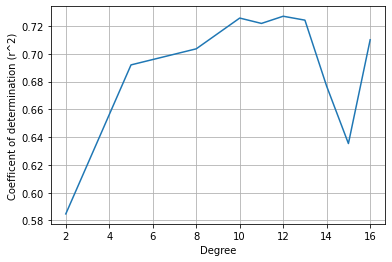

In [15]:
# Checking which degree we should use based on r^2
d = [2, 5, 8, 10, 11, 12, 13, 14, 15, 16]
cod_pr = []
for i in d:
    pred_DNP = pred_poly_reg(X_train2, Train2['Volum til DNP'], X_val2, i)
    cod_pr.append(coeff_of_determination(Val2['Volum til DNP'], pred_DNP))
 
                  
plt.plot(d, cod_pr)
plt.xlabel('Degree')
plt.ylabel('Coefficent of determination (r^2)')
plt.grid()
plt.show()

In [16]:
# Predicting values for volum til DNP using the polynomial regression

pred_DNP_poly = pred_poly_reg(X_train2, Train2['Volum til DNP'], X_val2, 12)
print('Coefficient of determination when using polynominal regression on validation data is:', str(coeff_of_determination(Val2['Volum til DNP'], pred_DNP_poly)))

Coefficient of determination when using polynominal regression on validation data is: 0.727075496588986


### Random Forrest Regression DNP

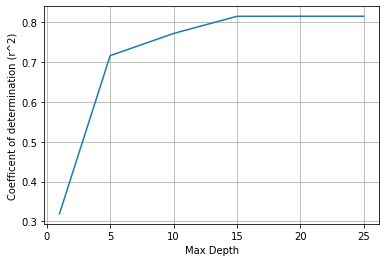

In [17]:
# Checking which max depth we should use based on r^2

hp_md = [1, 5, 10, 15, 20, 25]

cod_DNP = []

for i in hp_md:
    pred_DNP = pred_rfr(X_train, Train['Volum til DNP'], X_val, 100, i)
    cod_DNP.append(coeff_of_determination(Val['Volum til DNP'], pred_DNP))

    
plt.plot(hp_md, cod_DNP)
plt.xlabel('Max Depth')
plt.ylabel('Coefficent of determination (r^2)')
plt.grid()
plt.show()

In [18]:
pred_DNP_rfr = pred_rfr(X_train, Train['Volum til DNP'], X_val, 100, 15)
print('Coefficient of determination when using RandomForrestRegression on validation data is:', str(coeff_of_determination(Val['Volum til DNP'], pred_DNP_rfr)))

Coefficient of determination when using RandomForrestRegression on validation data is: 0.8147305085063202


### SVR DNP

In [19]:
# Predicting values for volum til DNP using the support vector regression

pred_DNP_svr = pred_svr(X_train2, Train2['Volum til DNP'], X_val2, 1.5, 0.2, 'rbf')
print('Coefficient of determination when using support vector regression on validation data is:', str(coeff_of_determination(Val2['Volum til DNP'], pred_DNP_svr)))

Coefficient of determination when using support vector regression on validation data is: 0.6785242682910122


## Til SNTR

### Polynominal Regression SNTR

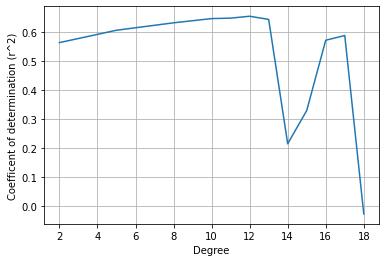

In [20]:
# Checking which degree we should use based on r^2

d = [2, 5, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18]
cod_pr = []
for i in d:
    pred_SNTR = pred_poly_reg(X_train2, Train2['Volum til SNTR'], X_val2, i)
    cod_pr.append(coeff_of_determination(Val2['Volum til SNTR'], pred_SNTR))
 
                  
plt.plot(d, cod_pr)
plt.xlabel('Degree')
plt.ylabel('Coefficent of determination (r^2)')
plt.grid()
plt.show()

In [21]:
# Predicting values for volum til DNP using the polynomial regression

pred_SNTR_poly = pred_poly_reg(X_train2, Train2['Volum til SNTR'], X_val2, 12)
print('Coefficient of determination when using polynominal regression on validation data is:', str(coeff_of_determination(Val2['Volum til SNTR'], pred_SNTR_poly)))

Coefficient of determination when using polynominal regression on validation data is: 0.6549213489081294


### Random Forrest Regression SNTR

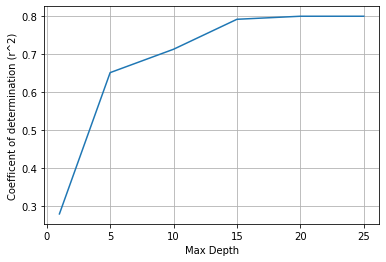

In [22]:
# Checking which max depth we should use based on r^2

hp_md = [1, 5, 10, 15, 20, 25]

cod_SNTR = []

for i in hp_md:
    pred_SNTR = pred_rfr(X_train, Train['Volum til SNTR'], X_val, 100, i)
    cod_SNTR.append(coeff_of_determination(Val['Volum til SNTR'], pred_SNTR))

    
plt.plot(hp_md, cod_SNTR)
plt.xlabel('Max Depth')
plt.ylabel('Coefficent of determination (r^2)')
plt.grid()
plt.show()

In [23]:
# Predicting values for volum til SNTR using the random forest regression

pred_SNTR_rfr = pred_rfr(X_train, Train['Volum til SNTR'], X_val, 100, 20)
print('Coefficient of determination when using RandomForrestRegression on validation data is:', str(coeff_of_determination(Val['Volum til SNTR'], pred_SNTR_rfr)))

Coefficient of determination when using RandomForrestRegression on validation data is: 0.8006031856526161


### SVR SNTR

In [24]:
# Predicting values for volum til SNTR using the support vector regression

pred_SNTR_svr = pred_svr(X_train2, Train2['Volum til SNTR'], X_val2, 1.5, 0.1, 'rbf')
print('Coefficient of determination when using support vector regression on validation data is:', str(coeff_of_determination(Val2['Volum til SNTR'], pred_SNTR_svr)))

Coefficient of determination when using support vector regression on validation data is: 0.5849524275258762


## Testing the best modells:

### Testing totalt 

Coefficient of determination on test data is: 0.8160416072736868


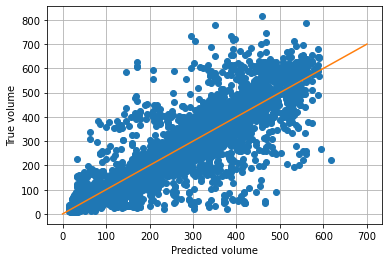

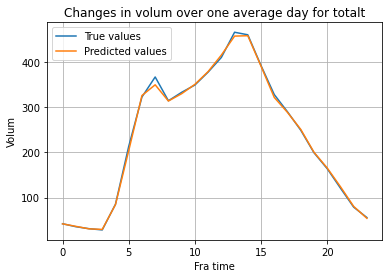

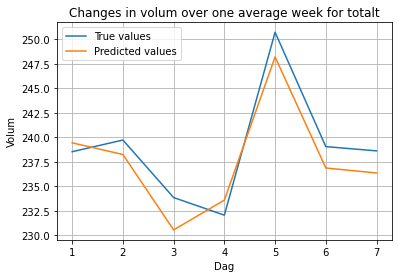

In [25]:
# Predicting the volum totalt for our test set on volum totalt

pred_test_tot = pred_rfr(X_train, Train['Volum totalt'], X_test, 100, 20)
print('Coefficient of determination on test data is:', str(coeff_of_determination(Test['Volum totalt'], pred_test_tot)))

# Plot over the predicted values against the true
x = np.arange(0, 800, 100).tolist()
plt.plot(pred_test_tot, Test['Volum totalt'], 'o')
plt.grid()
plt.xlabel('Predicted volume')
plt.ylabel('True volume')
plt.plot(x, x)
plt.show()

X_test['Volum totalt'] = pred_test_tot

# Plot over the predicted and true values based on average volum each hour
traffic_per_hour_true = Test[['Volum totalt','Fra_time']].groupby('Fra_time').mean()
traffic_per_hour_predicted = X_test[['Volum totalt','Fra_time']].groupby('Fra_time').mean()
ax = traffic_per_hour_true.plot()
traffic_per_hour_predicted.plot(ax=ax)
ax.legend(['True values', 'Predicted values'])
plt.grid()
plt.xlabel('Fra time')
plt.ylabel('Volum')
plt.title('Changes in volum over one average day for totalt')
plt.show()

# Plot over the predicted and true values based on average volum each day
traffic_per_day_true = Test[['Volum totalt','Dag']].groupby('Dag').mean()
traffic_per_day_predicted = X_test[['Volum totalt','Dag']].groupby('Dag').mean()
ax = traffic_per_day_true.plot()
traffic_per_day_predicted.plot(ax=ax)
ax.legend(['True values', 'Predicted values'])
plt.grid()
plt.xlabel('Dag')
plt.ylabel('Volum')
plt.title('Changes in volum over one average week for totalt')
plt.show()

X_test = X_test.drop(['Volum totalt'], axis = 1)

### Testing DNP

Coefficient of determination on test data is: 0.8095240623012723


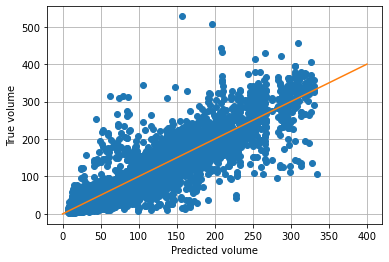

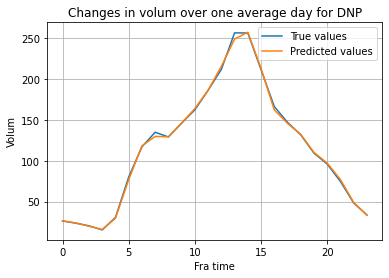

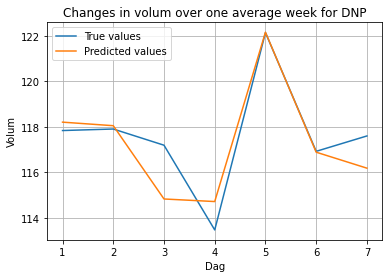

In [26]:
# Predicting the volum totalt for our test set on volum til DNP

pred_test_DNP = pred_rfr(X_train, Train['Volum til DNP'], X_test, 100, 20)
print('Coefficient of determination on test data is:', str(coeff_of_determination(Test['Volum til DNP'], pred_test_DNP)))

# Plot over the predicted values against the true
plt.plot(pred_test_DNP, Test['Volum til DNP'], 'o')
plt.grid()
plt.xlabel('Predicted volume')
plt.ylabel('True volume')
plt.plot([0,400], [0,400])
plt.show()

X_test['Volum til DNP'] = pred_test_DNP

traffic_per_hour_true = Test[['Volum til DNP','Fra_time']].groupby('Fra_time').mean()
traffic_per_hour_predicted = X_test[['Volum til DNP','Fra_time']].groupby('Fra_time').mean()
ax = traffic_per_hour_true.plot()
traffic_per_hour_predicted.plot(ax=ax)
ax.legend(['True values', 'Predicted values'])
plt.grid()
plt.xlabel('Fra time')
plt.ylabel('Volum')
plt.title('Changes in volum over one average day for DNP')
plt.show()


traffic_per_day_true = Test[['Volum til DNP','Dag']].groupby('Dag').mean()
traffic_per_day_predicted = X_test[['Volum til DNP','Dag']].groupby('Dag').mean()
ax = traffic_per_day_true.plot()
traffic_per_day_predicted.plot(ax=ax)
ax.legend(['True values', 'Predicted values'])
plt.grid()
plt.xlabel('Dag')
plt.ylabel('Volum')
plt.title('Changes in volum over one average week for DNP')
plt.show()

X_test = X_test.drop(['Volum til DNP'], axis = 1)

### Testing SNTR

Coefficient of determination on test data is: 0.7873062027267124


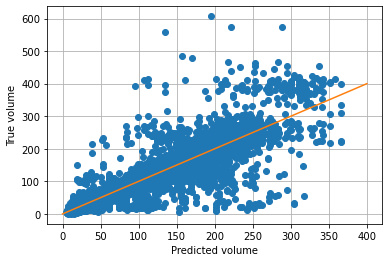

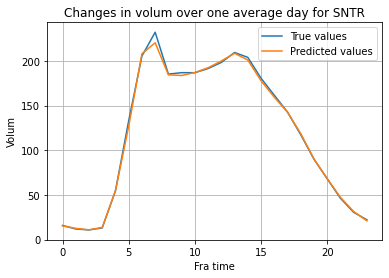

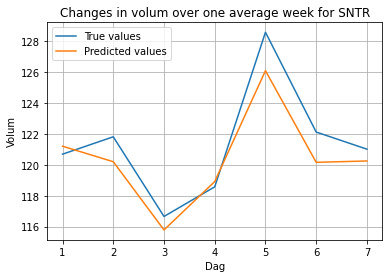

In [27]:
# Predicting the volum totalt for our test set on volum til SNTR

pred_test_SNTR = pred_rfr(X_train, Train['Volum til SNTR'], X_test, 100, 20)
print('Coefficient of determination on test data is:', str(coeff_of_determination(Test['Volum til SNTR'], pred_test_SNTR)))

# Plot over the predicted values against the true
plt.plot(pred_test_SNTR, Test['Volum til SNTR'], 'o')
plt.grid()
plt.xlabel('Predicted volume')
plt.ylabel('True volume')
plt.plot([0,400], [0,400])
plt.show()

X_test['Volum til SNTR'] = pred_test_SNTR

traffic_per_hour_true = Test[['Volum til SNTR','Fra_time']].groupby('Fra_time').mean()
traffic_per_hour_predicted = X_test[['Volum til SNTR','Fra_time']].groupby('Fra_time').mean()
ax = traffic_per_hour_true.plot()
traffic_per_hour_predicted.plot(ax=ax)
ax.legend(['True values', 'Predicted values'])
plt.grid()
plt.xlabel('Fra time')
plt.ylabel('Volum')
plt.title('Changes in volum over one average day for SNTR')
plt.show()


traffic_per_day_true = Test[['Volum til SNTR','Dag']].groupby('Dag').mean()
traffic_per_day_predicted = X_test[['Volum til SNTR','Dag']].groupby('Dag').mean()
ax = traffic_per_day_true.plot()
traffic_per_day_predicted.plot(ax=ax)
ax.legend(['True values', 'Predicted values'])
plt.grid()
plt.xlabel('Dag')
plt.ylabel('Volum')
plt.title('Changes in volum over one average week for SNTR')
plt.show()

X_test = X_test.drop(['Volum til SNTR'], axis = 1)

## Testing the dataset from 2020:

In [28]:
# Fixing the dataset for 2020 such that the features will be on the same form as our first dataset

dataset_2020 = pd.read_csv('data_2020.csv')


lst = [3,4,5,6,7,1,2]
n = len(dataset['Dag'])
dag=(lst*int(n/7))
dag.append(3)
dag.append(4)
dag.append(5)

df1 = pd.DataFrame({'Dag':dag})

måned = np.array(dataset_2020['Måned'])

for i in range(len(måned)):
    if måned[i] == 7:
        måned[i] = 1
    elif måned[i] in [5,6,8,9,10,11]:
        måned[i] = 2
    else:
        måned[i] = 3


df2_2020 = pd.DataFrame({'Måned':måned})

dataset_2020 = dataset_2020.assign(Dag=df1['Dag'])
dataset_2020=dataset_2020.assign(Måned=df2_2020['Måned'])


encdf_2020 = pd.DataFrame(enc.fit_transform(dataset_2020.drop(['Fra_time', 'Dag', 'År', 'Volum totalt', 'Volum til DNP', 'Volum til SNTR'], axis=1)).toarray())
encdf_2020['År'] = np.array(dataset_2020['År'])
encdf_2020['Dag'] = np.array(dataset_2020['Dag'])
encdf_2020['Fra_time'] = np.array(dataset_2020['Fra_time'])
encdf_2020.columns = ['Juli', 'Sommertid', 'Vintertid', 'År', 'Dag', 'Fra_time']
print(encdf_2020.head())

   Juli  Sommertid  Vintertid    År  Dag  Fra_time
0   0.0        0.0        1.0  2020    3         0
1   0.0        0.0        1.0  2020    4         1
2   0.0        0.0        1.0  2020    5         2
3   0.0        0.0        1.0  2020    6         3
4   0.0        0.0        1.0  2020    7         4


### Testing totalt 2020

Coefficient of determination on 2020 data, for totalt, is: 0.6053929990114575


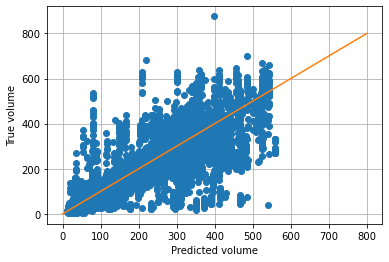

In [29]:
# Make predictions for 2020
pred_2020_tot = pred_rfr(X_train, Train['Volum totalt'], encdf_2020, 100, 20)
print('Coefficient of determination on 2020 data, for totalt, is:', str(coeff_of_determination(dataset_2020['Volum totalt'], pred_2020_tot)))

# Plots the predictions against the true values 
plt.plot(pred_2020_tot, dataset_2020['Volum totalt'], 'o')
plt.grid()
plt.xlabel('Predicted volume')
plt.ylabel('True volume')
plt.plot([0,800], [0,800])
plt.show()

### Testing DNP 2020

Coefficient of determination on 2020 data, for DNP, is: 0.6344087631486547


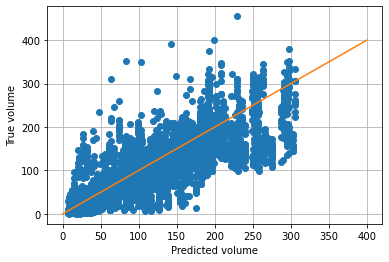

In [30]:
pred_2020_DNP = pred_rfr(X_train, Train['Volum til DNP'], encdf_2020, 100, 20)
print('Coefficient of determination on 2020 data, for DNP, is:', str(coeff_of_determination(dataset_2020['Volum til DNP'], pred_2020_DNP)))


plt.plot(pred_2020_DNP, dataset_2020['Volum til DNP'], 'o')
plt.grid()
plt.xlabel('Predicted volume')
plt.ylabel('True volume')
plt.plot([0,400], [0,400])
plt.show()

### Testing SNTR 2020

Coefficient of determination on 2020 data, for SNTR, is: 0.5528145114780434


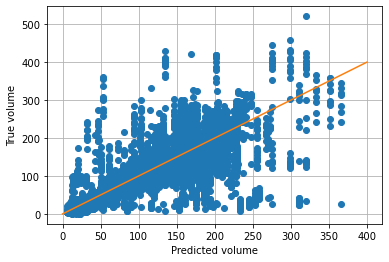

In [31]:
pred_2020_SNTR = pred_rfr(X_train, Train['Volum til SNTR'], encdf_2020, 100, 20)
print('Coefficient of determination on 2020 data, for SNTR, is:', str(coeff_of_determination(dataset_2020['Volum til SNTR'], pred_2020_SNTR)))


plt.plot(pred_2020_SNTR, dataset_2020['Volum til SNTR'], 'o')
plt.grid()
plt.xlabel('Predicted volume')
plt.ylabel('True volume')
plt.plot([0,400], [0,400])
plt.show()